In [1]:
!pip install torchdiffeq

# Imports

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

adjoint = True
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data

In [3]:
data_size = 1000

true_h0 = torch.tensor([[2., 0.]])
t = torch.linspace(0., 25., data_size)
true_A = torch.tensor([[-0.1, -1.], [1., -0.1]])

class Lambda(nn.Module):
    def forward(self, t, h):
        return h @ true_A

with torch.no_grad():
    true_h = odeint(Lambda(), true_h0, t)

print(true_h.shape)

torch.Size([1000, 1, 2])


In [4]:
test_t = torch.linspace(0., 50., data_size)
with torch.no_grad():
    test_h = odeint(Lambda(), true_h0, test_t)

print(true_h.shape)

torch.Size([1000, 1, 2])


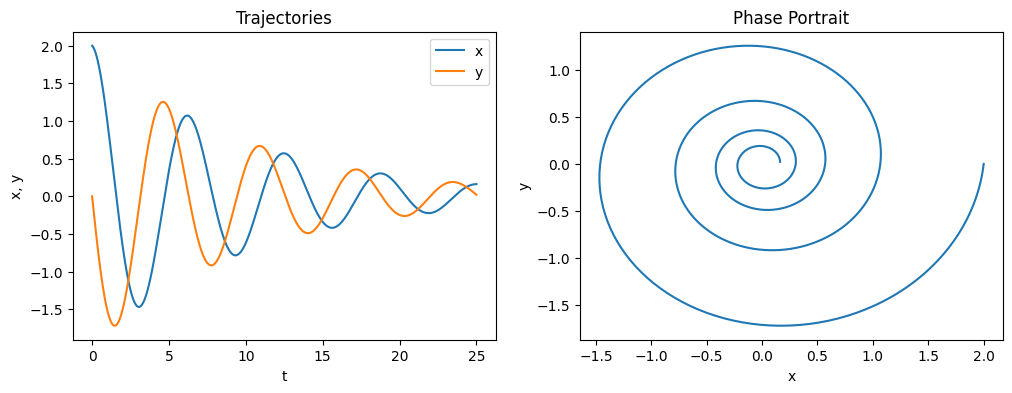

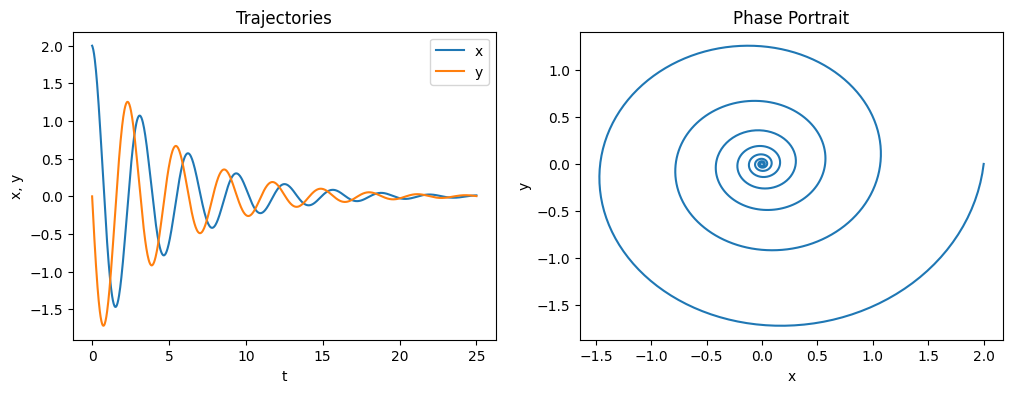

In [5]:
def visualize(true_h, pred_h=None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(t.numpy(), true_h.numpy()[:, 0, 0])
    axs[0].plot(t.numpy(), true_h.numpy()[:, 0, 1])
    axs[0].set_xlabel('t')
    axs[0].set_ylabel('x, y')
    axs[0].set_title('Trajectories')
    axs[0].legend(['x', 'y'])

    axs[1].plot(true_h.numpy()[:, 0, 0], true_h.numpy()[:, 0, 1])
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('y')
    axs[1].set_title('Phase Portrait')

    if pred_h is not None:
        axs[0].plot(t.numpy(), pred_h.numpy()[:, 0, 0], 'g--')
        axs[0].plot(t.numpy(), pred_h.numpy()[:, 0, 1], 'r--')
        axs[0].legend(['x', 'y', 'x*', 'y*'])

        axs[1].plot(pred_h.numpy()[:, 0, 0], pred_h.numpy()[:, 0, 1], '--')
    plt.show()

visualize(true_h)
visualize(test_h)

# Model

In [7]:
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.Tanh(),
            nn.Linear(32, 2),
        )

    def forward(self, t, h):
        return self.net(h)

# Tests

In [8]:
def get_data(batch_time=32):
    index_range = np.arange(data_size)
    t0 = np.random.choice(index_range[:-batch_time])
    idx = torch.tensor(np.array([t0 + i for i in range(batch_time)]))
    batch_h = true_h[idx]
    return batch_h[0], t[idx], batch_h

###### TEST ######

test_batch_h0, test_batch_t, test_batch_h = get_data()
test_batch_h0.shape, test_batch_t.shape, test_batch_h.shape

(torch.Size([1, 2]), torch.Size([32]), torch.Size([32, 1, 2]))

Iter 0020 | Total Loss 2.572510


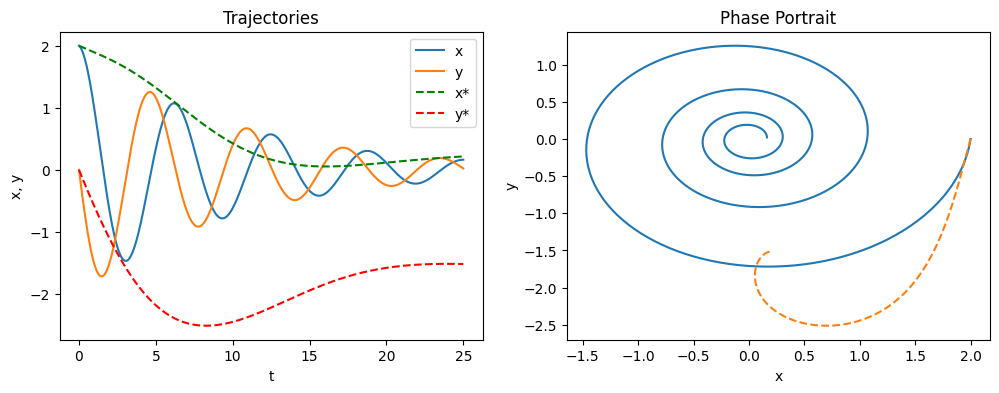

Iter 0040 | Total Loss 1.244649


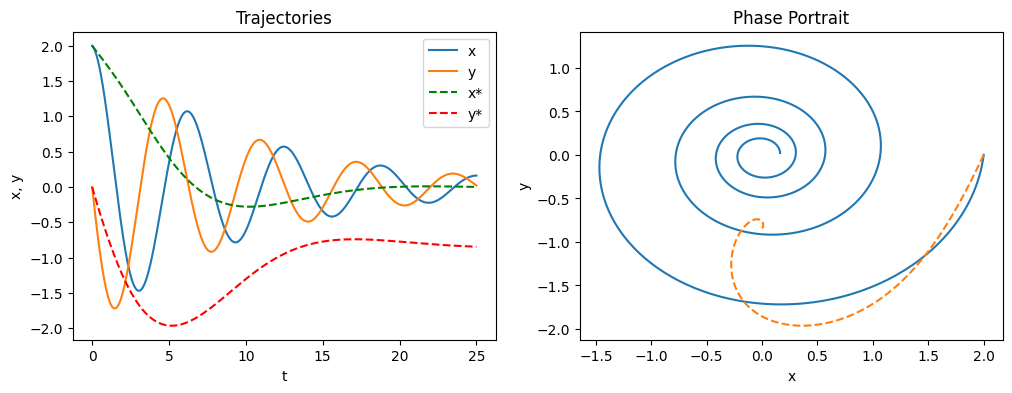

Iter 0060 | Total Loss 0.818318


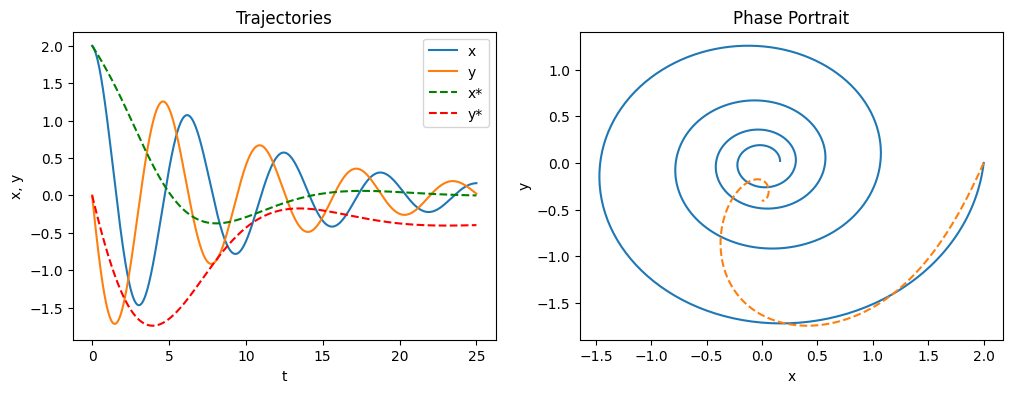

Iter 0080 | Total Loss 0.733342


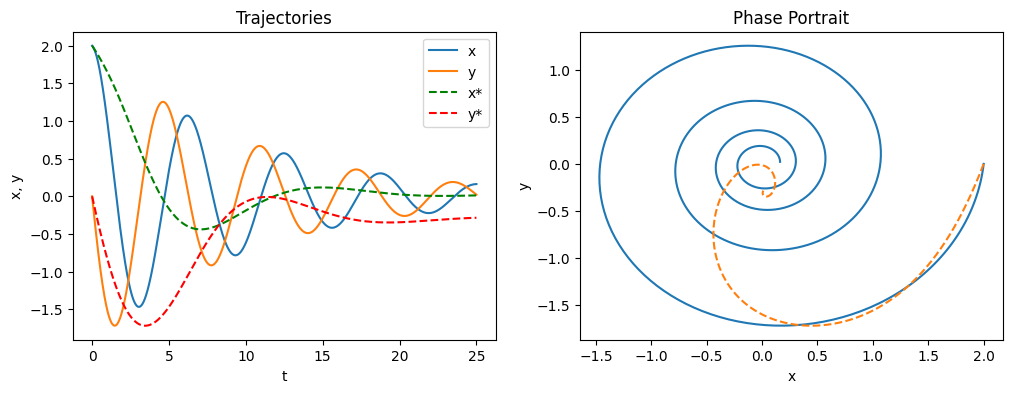

Iter 0100 | Total Loss 0.602468


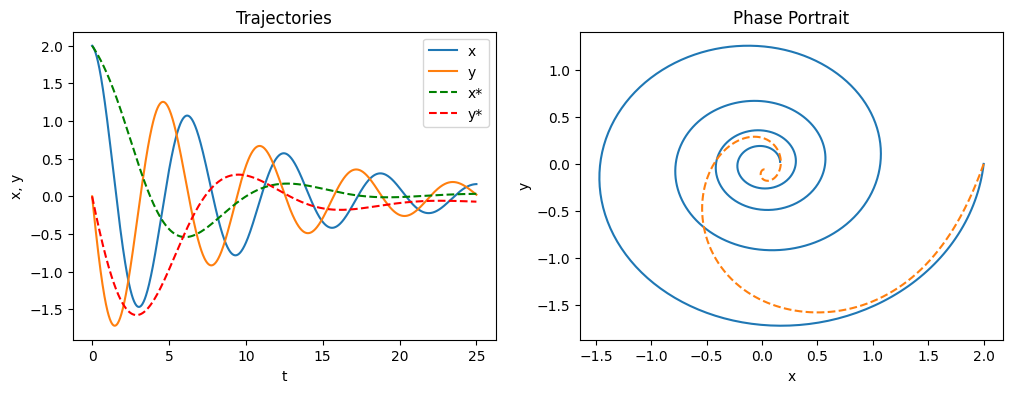

Iter 0120 | Total Loss 0.550223


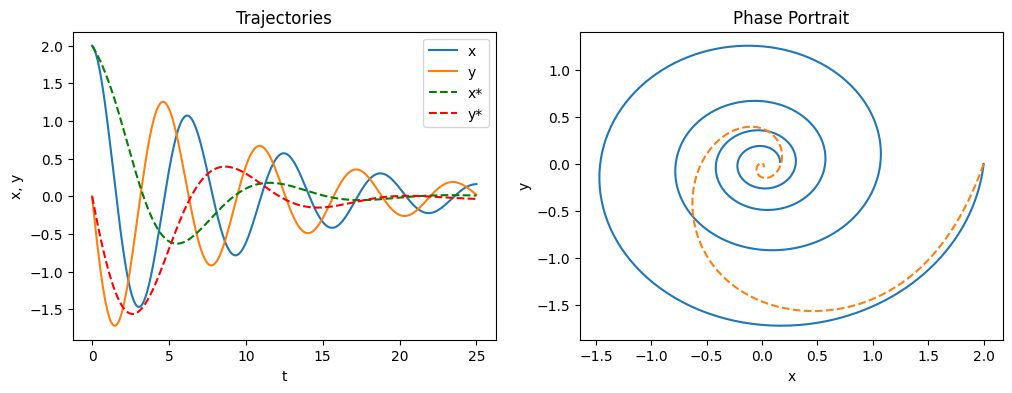

Iter 0140 | Total Loss 0.480516


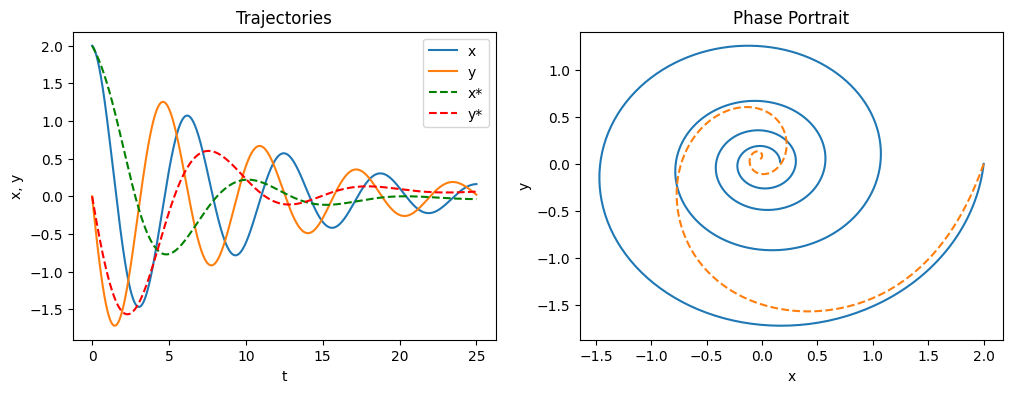

Iter 0160 | Total Loss 0.435387


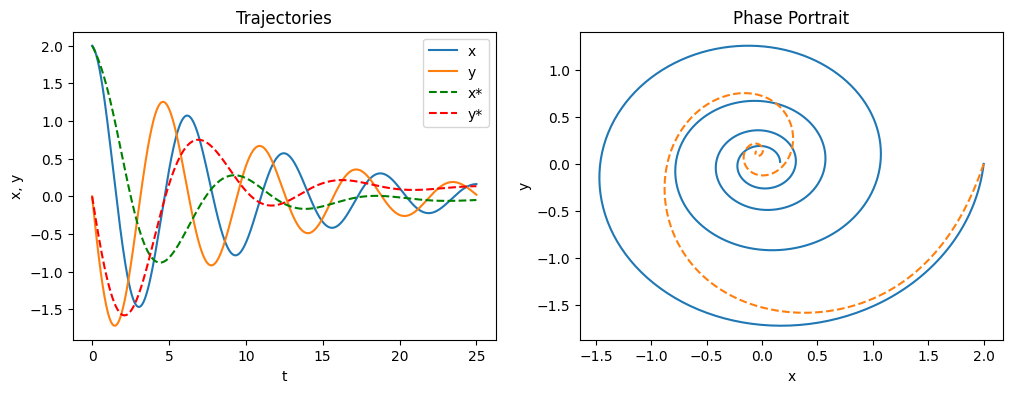

Iter 0180 | Total Loss 0.409391


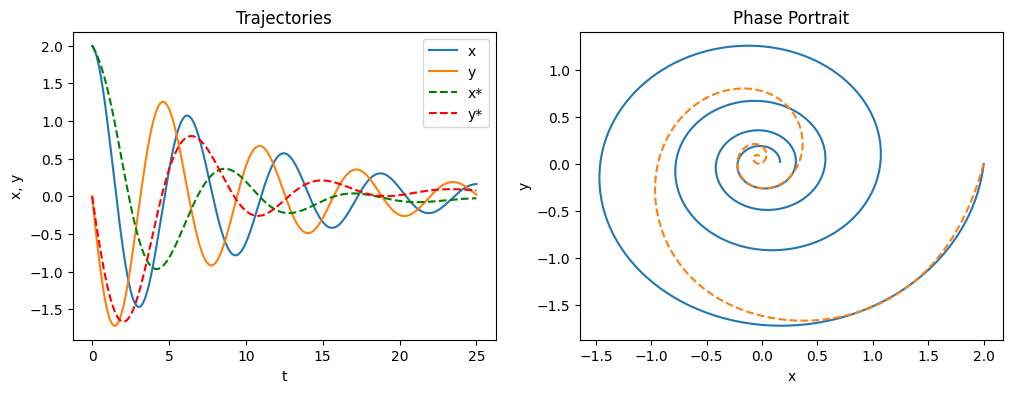

Iter 0200 | Total Loss 0.367752


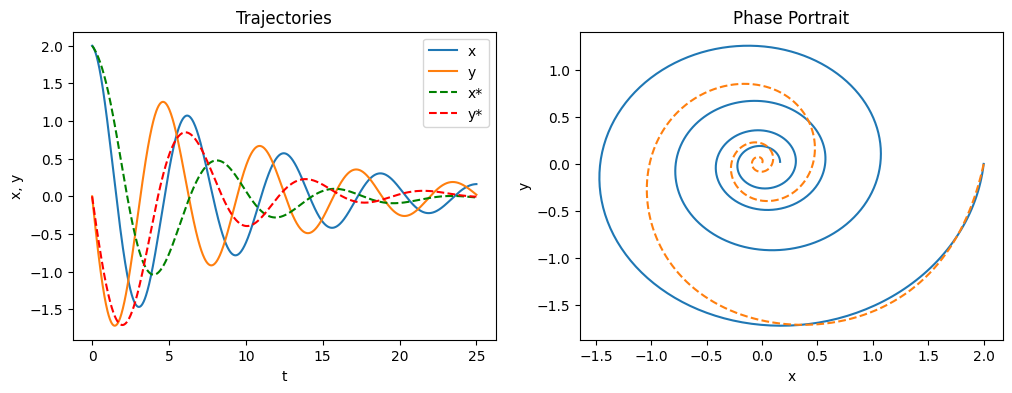

Iter 0220 | Total Loss 0.300238


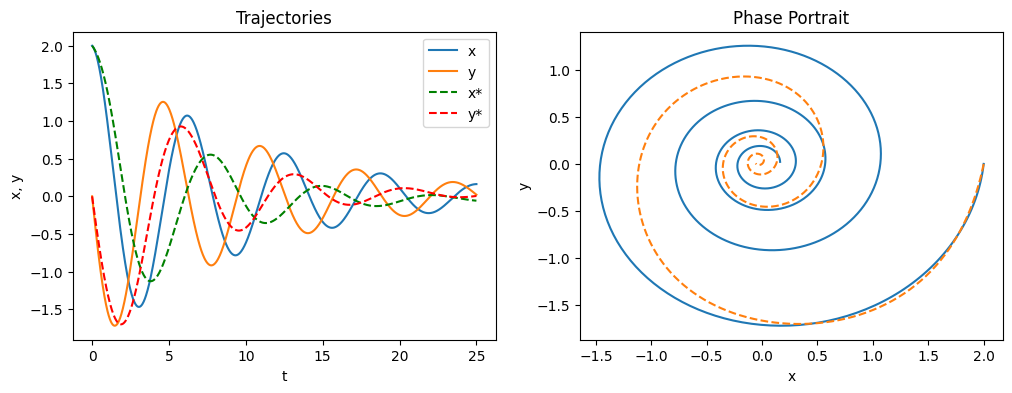

Iter 0240 | Total Loss 0.237919


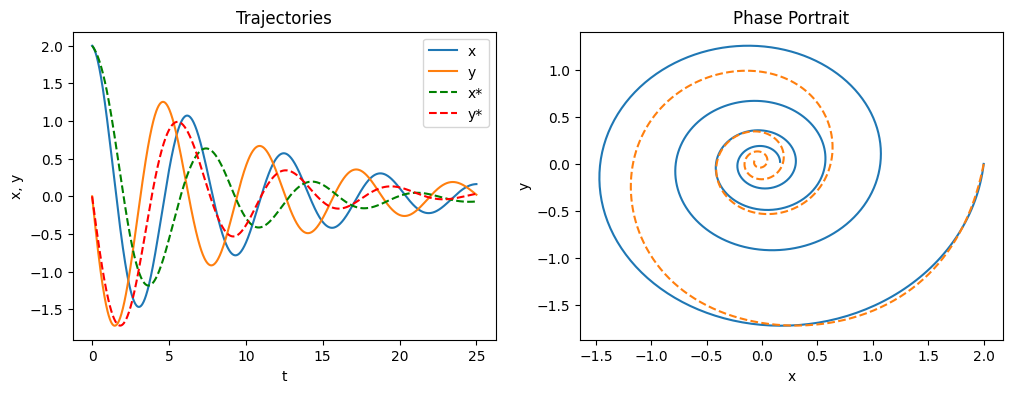

Iter 0260 | Total Loss 0.178865


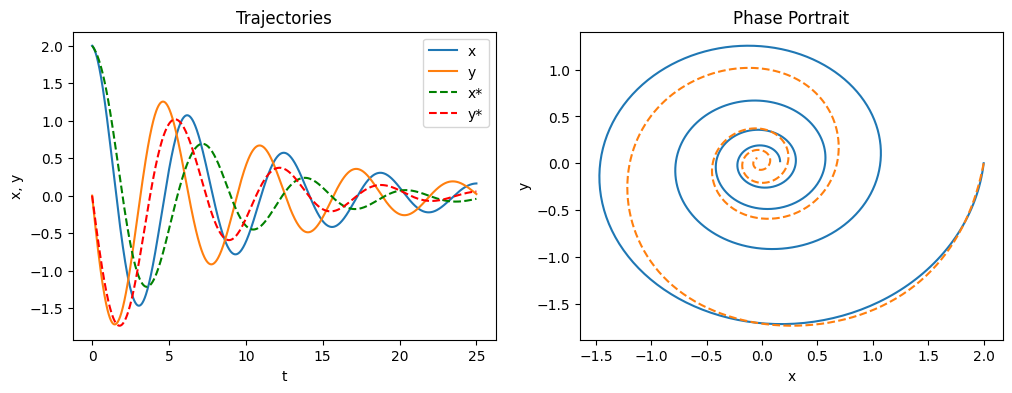

Iter 0280 | Total Loss 0.123863


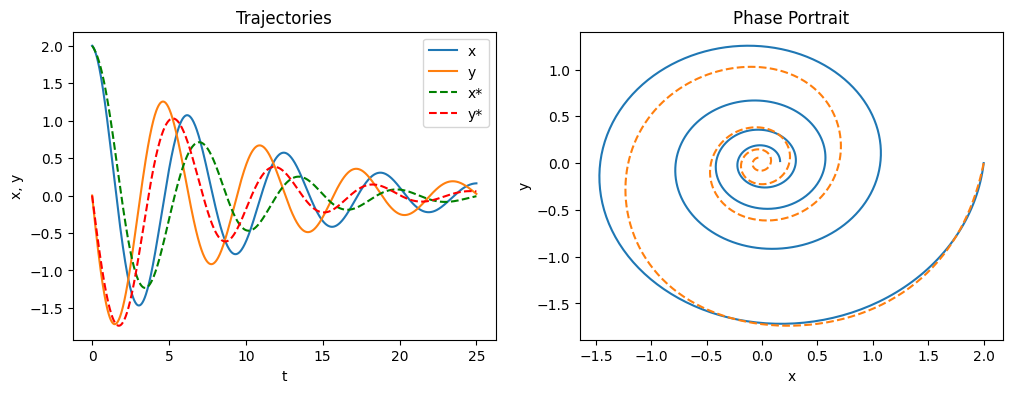

Iter 0300 | Total Loss 0.106535


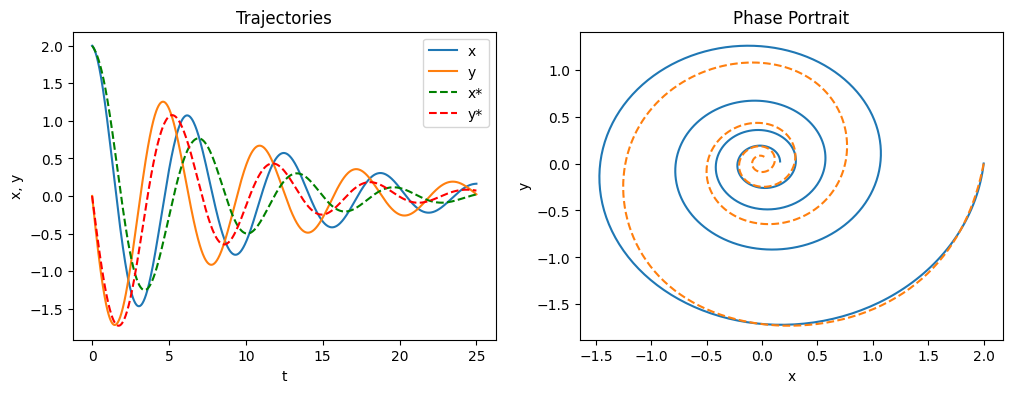

Iter 0320 | Total Loss 0.074015


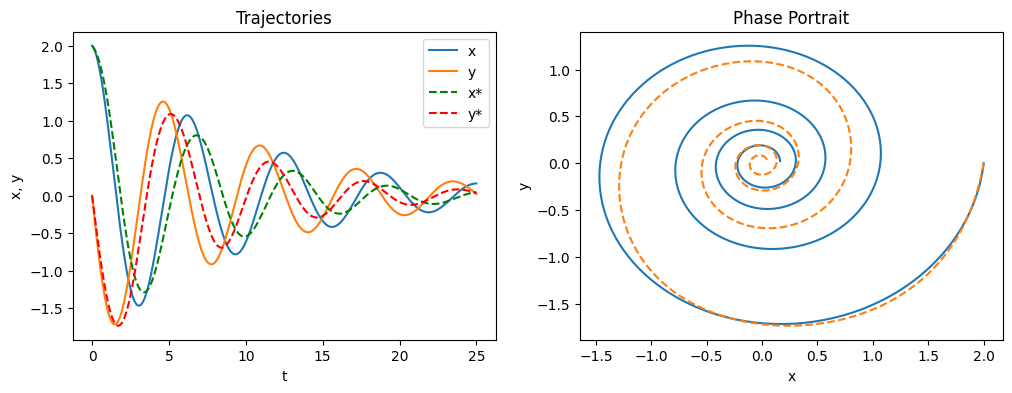

Iter 0340 | Total Loss 0.042749


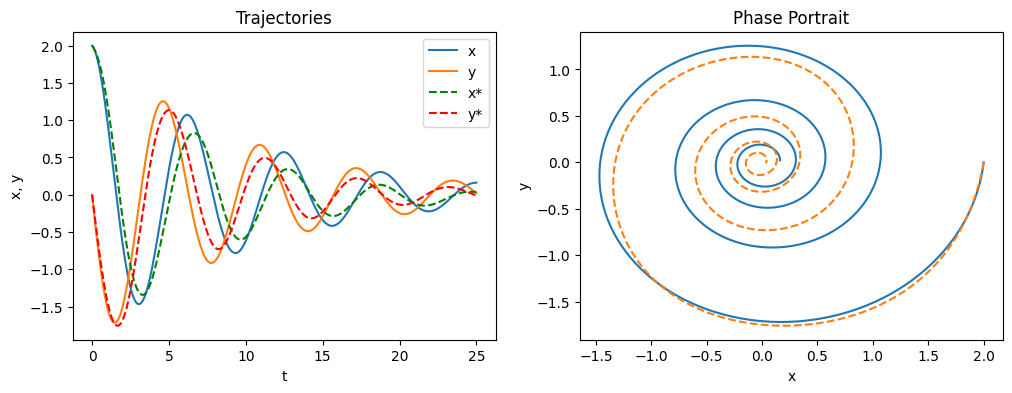

Iter 0360 | Total Loss 0.029581


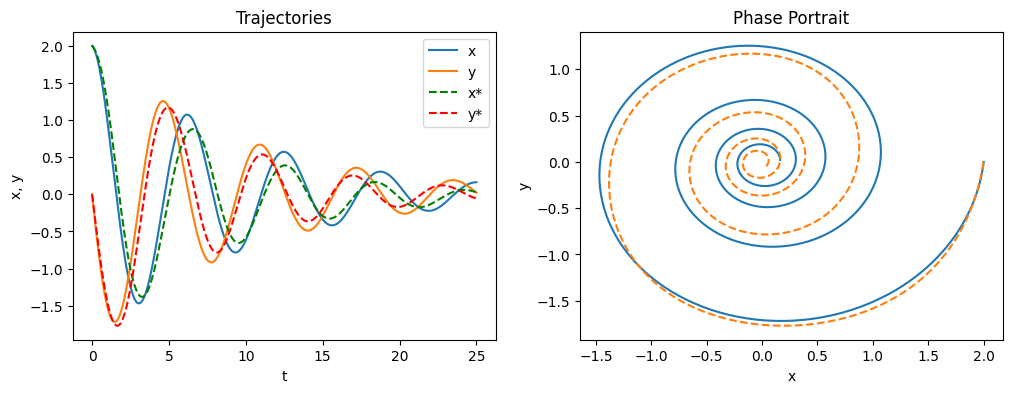

Iter 0380 | Total Loss 0.027212


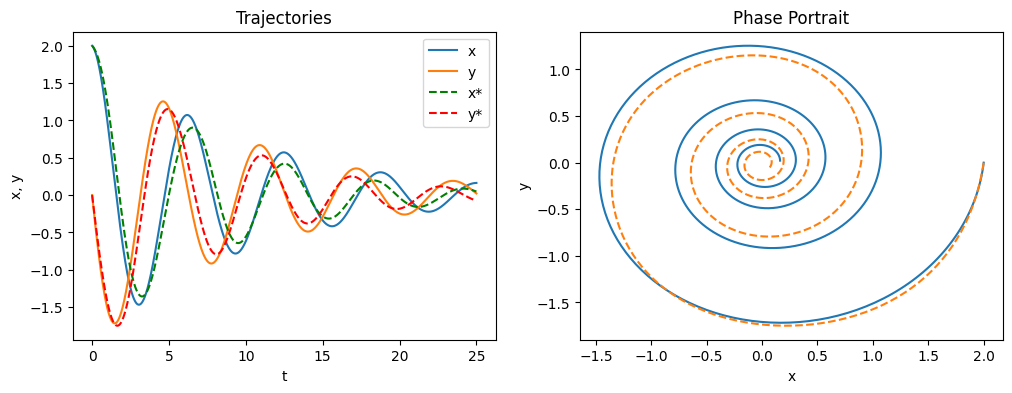

Iter 0400 | Total Loss 0.029673


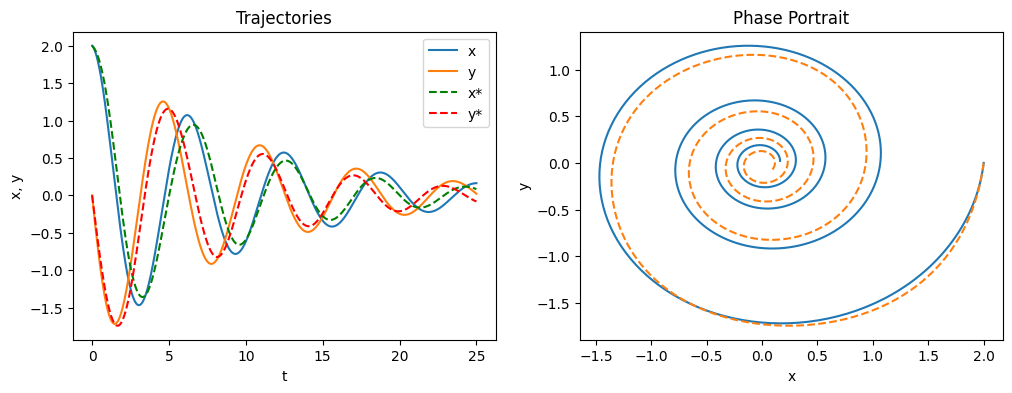

Iter 0420 | Total Loss 0.023543


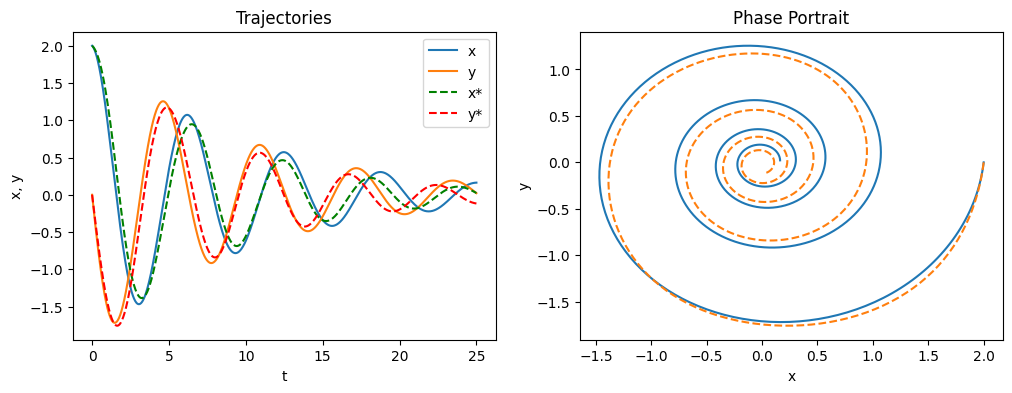

Iter 0440 | Total Loss 0.022860


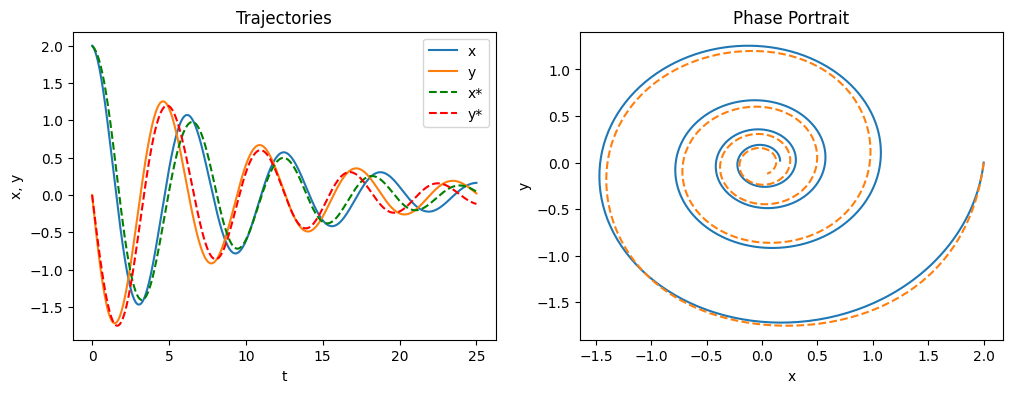

Iter 0460 | Total Loss 0.021967


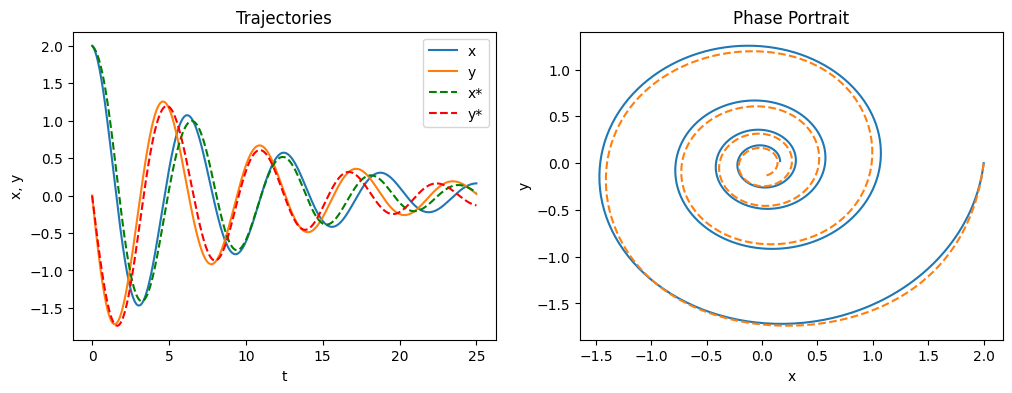

Iter 0480 | Total Loss 0.023826


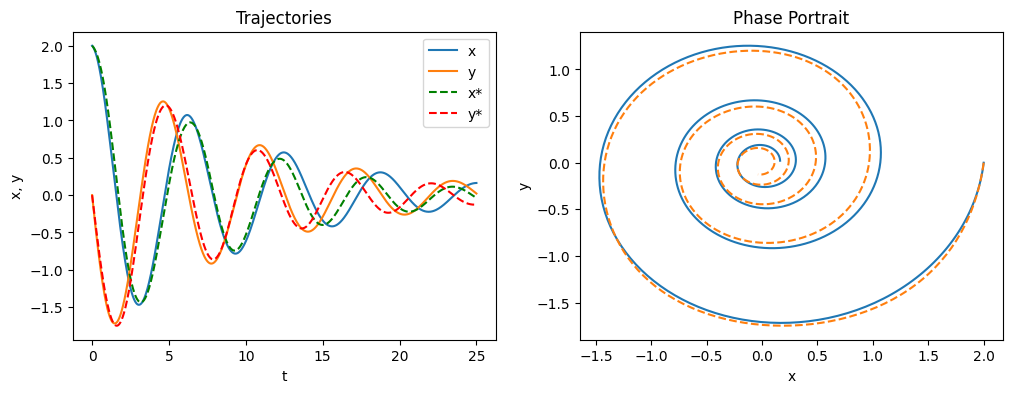

Iter 0500 | Total Loss 0.023440


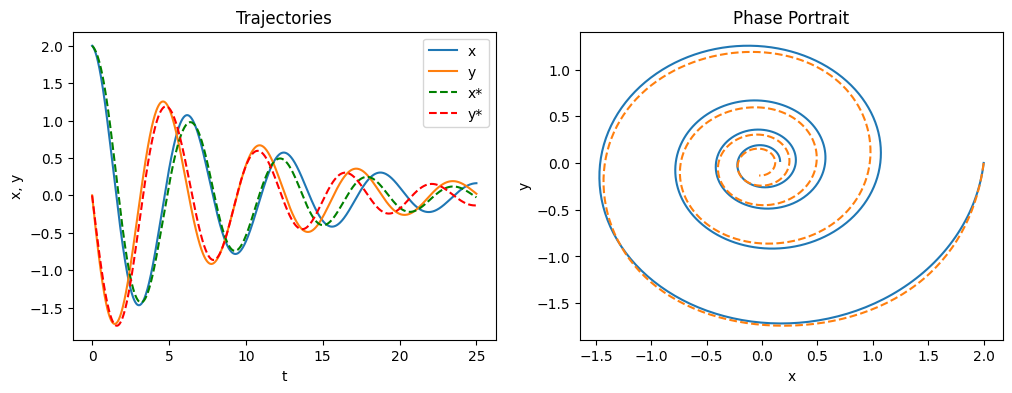

In [9]:
niters = 500
test_freq = 20

func = ODEFunc()
optimizer = optim.Adam(func.parameters(), lr=1e-3)

for itr in range(1, niters + 1):
    optimizer.zero_grad()
    batch_h0, batch_t, batch_h = get_data()
    pred_h = odeint(func, batch_h0, batch_t)
    loss = torch.mean(F.mse_loss(pred_h, batch_h))
    loss.backward()
    optimizer.step()

    if itr % test_freq == 0:
        with torch.no_grad():
            pred_h = odeint(func, true_h0, t)
            loss = torch.mean(F.mse_loss(pred_h, true_h))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            visualize(true_h, pred_h)


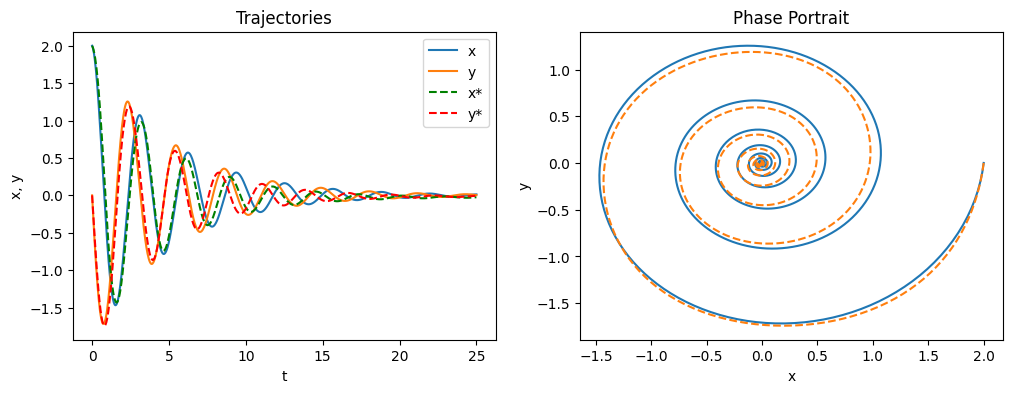

In [10]:
with torch.no_grad():
    pred_h = odeint(func, true_h0, test_t)
    visualize(test_h, pred_h)